# Mixture density network

In [1]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

from functools import partial
from chex import dataclass
from flax.training.train_state import TrainState

In [2]:
%config InlineBackend.figure_format="retina"

In [3]:
key = jax.random.PRNGKey(314)
key_data, key_train = jax.random.split(key)
key_x, key_y = jax.random.split(key_data)

In [4]:
n_samples = 200

x = jax.random.uniform(key_x, minval=0, maxval=1, shape=(n_samples,))
noise  = jax.random.uniform(key_y, minval=-0.1, maxval=0.1, shape=(n_samples,))
y = x + 0.3 * jnp.sin(2 * jnp.pi * x) + noise

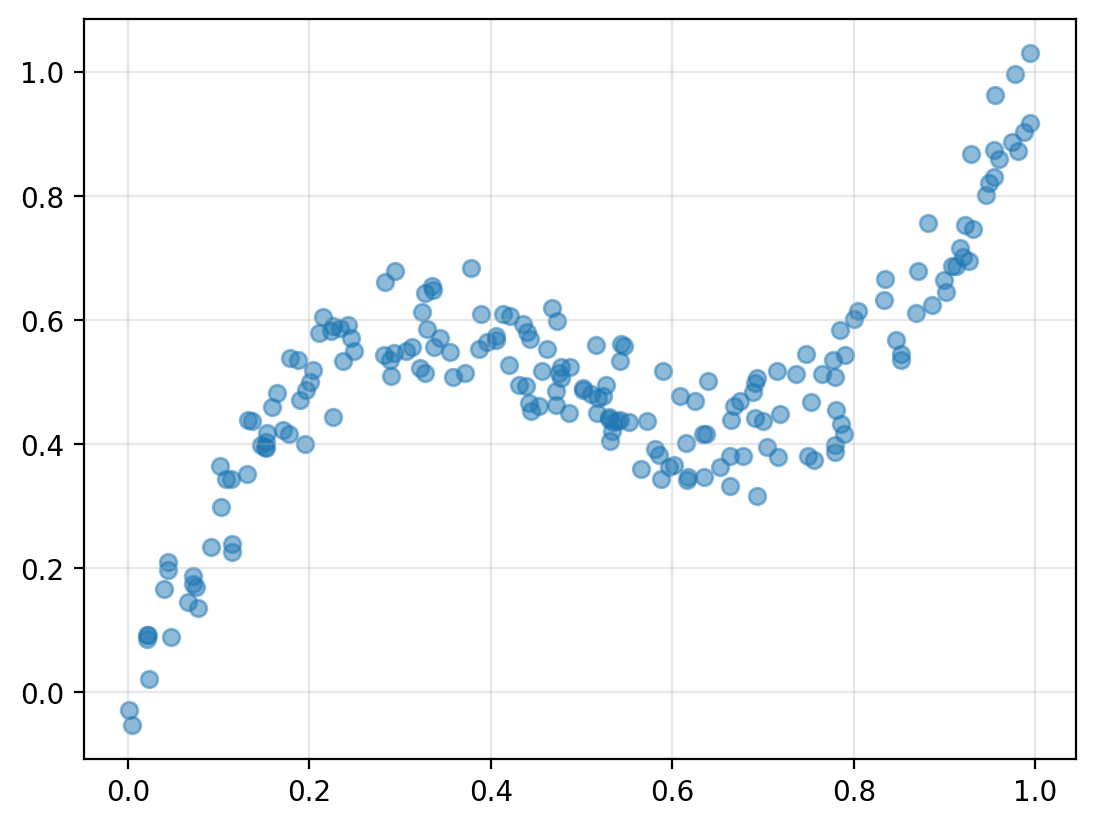

In [5]:
plt.scatter(x, y, alpha=0.5)
plt.grid(alpha=0.3)

## The forward and inverse problems

In [6]:
class SimpleMLP(nn.Module):
    n_hidden: int
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(6)(x)
        x = nn.tanh(x)
        x = nn.Dense(6)(x)
        x = nn.tanh(x)
        x = nn.Dense(1)(x)
        return x

In [7]:
def lossfn(params, x, y, apply_fn):
    yhat = apply_fn(params, x[:, None]).ravel()
    return jnp.power(y - yhat, 2).mean()
    

def train_step(state, i, x, y):
    loss, grads = jax.value_and_grad(lossfn)(state.params, x, y, state.apply_fn)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [8]:
model = SimpleMLP(n_hidden=6)
params_init = model.init(key_train, x[:, None])
state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(1e-2)
)

In [9]:
part_step = partial(train_step, x=x, y=y)
n_steps = 10_000
steps = jnp.arange(n_steps)
state_final, losses = jax.lax.scan(part_step, state, steps)

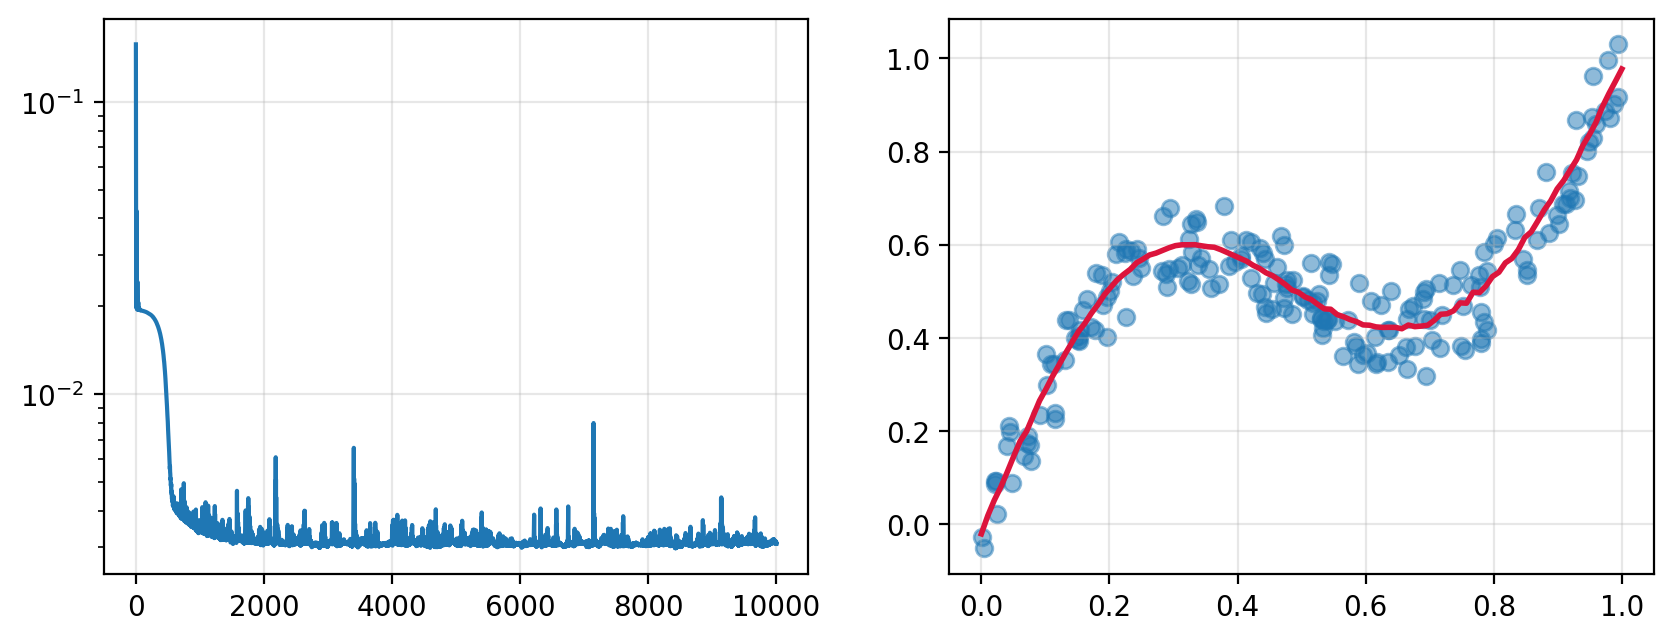

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3.6))

ax[0].plot(losses)
ax[0].set_yscale("log")
ax[0].grid(alpha=0.3)

xrange = jnp.linspace(0, 1, 100)
yhat = model.apply(state_final.params, xrange[:, None])
ax[1].plot(xrange, yhat, c="crimson", linewidth=2)
ax[1].scatter(x, y, alpha=0.5)
ax[1].grid(alpha=0.3)

In [11]:
part_step = partial(train_step, x=y, y=x)
n_steps = 10_000
steps = jnp.arange(n_steps)
state_final, losses = jax.lax.scan(part_step, state, steps)

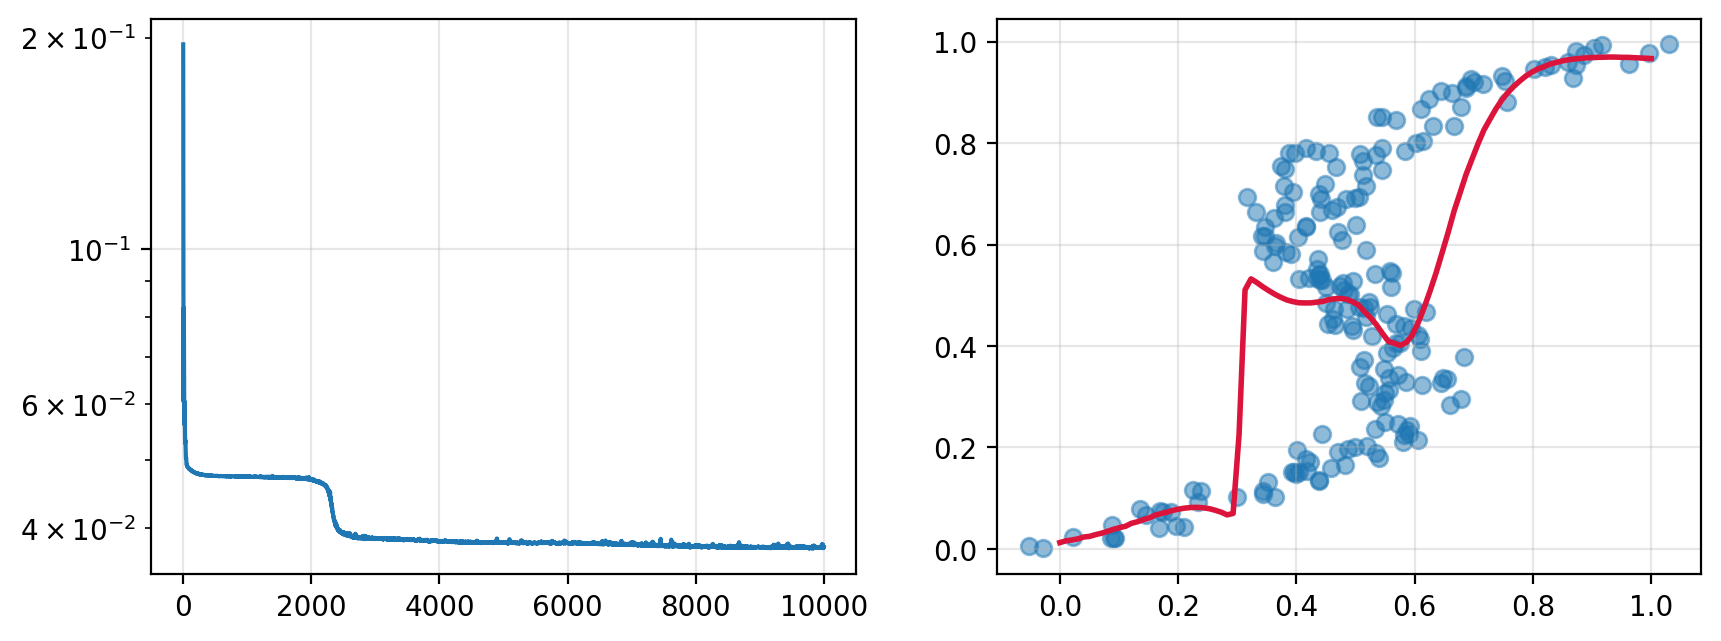

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3.6))

ax[0].plot(losses)
ax[0].set_yscale("log")
ax[0].grid(alpha=0.3)

xrange = jnp.linspace(0, 1, 100)
yhat = model.apply(state_final.params, xrange[:, None])
ax[1].plot(xrange, yhat, c="crimson", linewidth=2)
ax[1].scatter(y, x, alpha=0.5)
ax[1].grid(alpha=0.3)

## Mixture density network

In [116]:
class MixDN(nn.Module):
    n_components: int
    n_hidden: int
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = nn.tanh(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.tanh(x)
        
        mu = nn.Dense(self.n_components, name="mu")(x)
        sigma = nn.Dense(self.n_components, name="sigma")(x)
        pi = nn.Dense(self.n_components, name="pi")(x)
        
        sigma = jnp.exp(sigma / 2)
        pi = nn.softmax(pi)
        
        return mu, sigma, pi

In [117]:
def lossfn(params, x, y, apply_fn):
    mu, sigma, pi = apply_fn(params, x[:, None])
    E = -jnp.log((distrax.Normal(mu, sigma).prob(y[:, None]) * pi).sum(axis=1)).sum()
    return E


def train_step(state, i, x, y):
    loss, grads = jax.value_and_grad(lossfn)(state.params, x, y, state.apply_fn)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [167]:
model = MixDN(n_hidden=6, n_components=3)
params_init = model.init(key_train, x[:, None])
state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(1e-3)
)

In [168]:
part_step = partial(train_step, x=x, y=y)
n_steps = 10_000
steps = jnp.arange(n_steps)
state_final, losses = jax.lax.scan(part_step, state, steps)

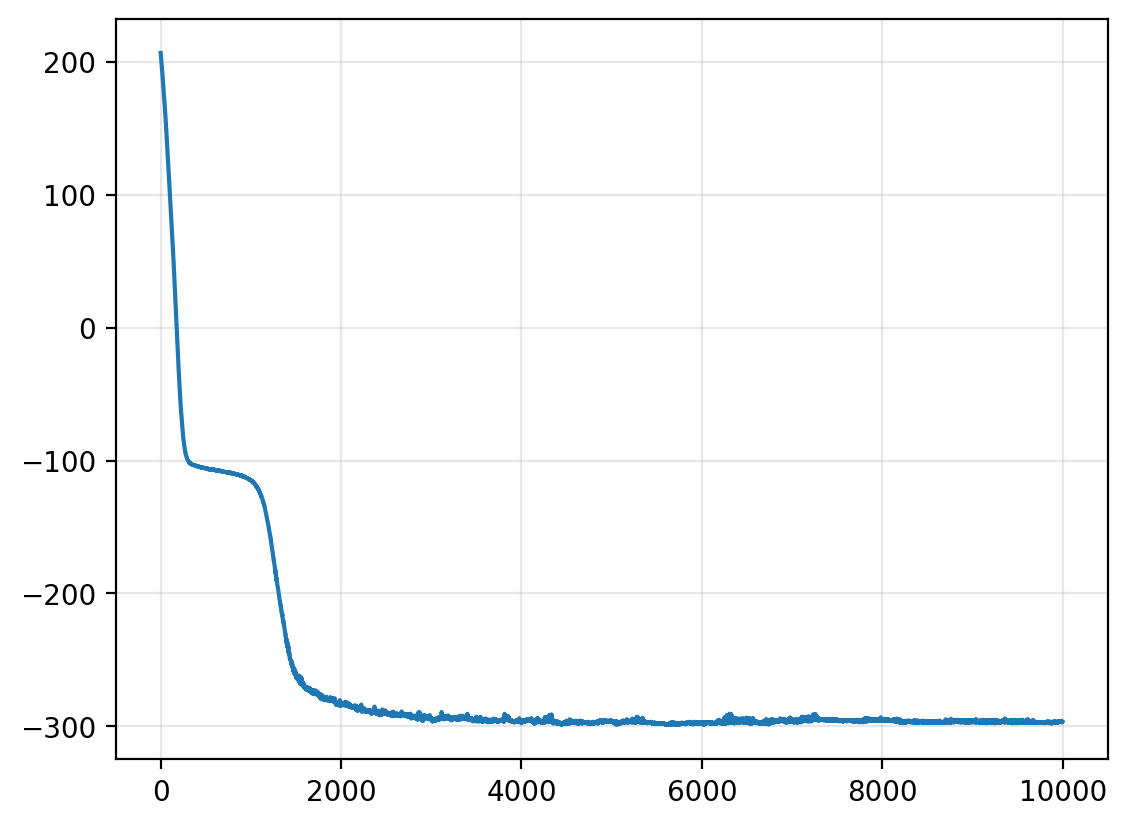

In [169]:
plt.plot(losses)
plt.grid(alpha=0.3)

In [170]:
@partial(jax.vmap, in_axes=(None, 0, None, None))
@partial(jax.vmap, in_axes=(None, None, 0, None))
def eval_mdn(params, x, y, apply_fn):
    x = jnp.atleast_1d(x)
    y = jnp.atleast_1d(y)
    mu, sigma, pi = apply_fn(params, x)
    density = (distrax.Normal(mu, sigma).prob(y) * pi).sum(axis=-1)
    return density

In [171]:
xeval = jnp.linspace(0, 1, 50)
yeval = jnp.linspace(0, 1, 20)

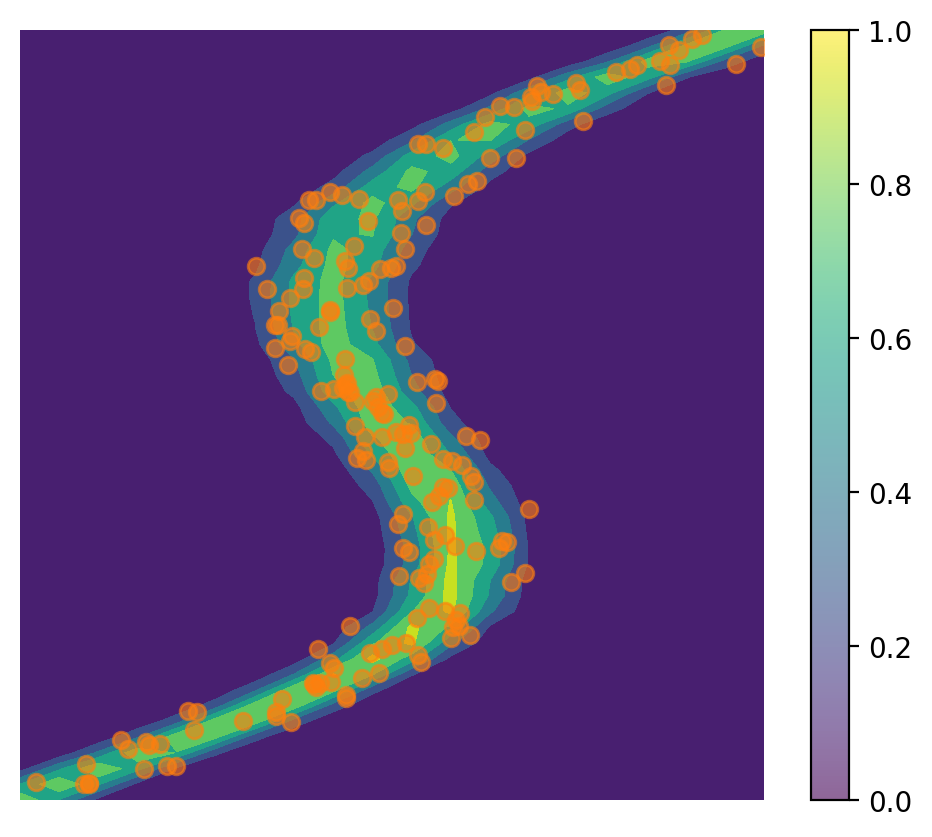

In [172]:
plt.figure(figsize=(6, 5))
density_map = eval_mdn(state_final.params, xeval, yeval, state.apply_fn)
plt.contourf(yeval, xeval, density_map)
plt.xlim(0, 1)
plt.scatter(y, x, c="tab:orange", alpha=0.6)
plt.axis("off")
plt.colorbar();